# 01 – Walkthrough (Test Set Includes Positives)

This version adjusts the train/val/test split so the **test set contains fault (positive) samples**, enabling a real PR/ROC evaluation.

### Updated split (by battery):
- **Train:** B0005
- **Validation:** B0006
- **Test:** B0018  ✅ contains positives

We keep **WIN=256** (baseline) and regenerate windows before training.


In [2]:
# Imports and config check
from src import config
print('DATA_DIR    =', config.DATA_DIR)
print('WINDOWS_DIR =', config.WINDOWS_DIR)
print('RUNS_DIR    =', config.RUNS_DIR)
print('WIN/STRIDE  =', config.WIN, config.STRIDE)


DATA_DIR    = C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\Data\battery_data
WINDOWS_DIR = C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\Data\windows
RUNS_DIR    = C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\runs
WIN/STRIDE  = 256 64


## 1) Preprocess
This loads the NASA `.mat` files, extracts discharge data, labels faults using the capacity threshold, and writes `processed.parquet`.


In [3]:
from src import preprocess
preprocess.main()

[preprocess] wrote C:\Users\Sobhi\OneDrive\Documents\ece5831-2025-assignments\Project\Data\processed.parquet rows=185721
[preprocess] per-battery fault rate:
battery_id
B0005    0.2654
B0006    0.3590
B0007    0.0000
B0018    0.1690
Name: fault, dtype: float64
[preprocess] overall fault rate: 0.2008


## 2) Set split so **test has positives**
We override the split in-memory for this notebook session.

> If you want this permanent, also update the same variables in `src/config.py`.


In [4]:
from src import config

print('TRAIN_BATTS =', config.TRAIN_BATTS)
print('VAL_BATTS   =', config.VAL_BATTS)
print('TEST_BATTS  =', config.TEST_BATTS)


TRAIN_BATTS = ['B0005']
VAL_BATTS   = ['B0006']
TEST_BATTS  = ['B0018']


## 3) Regenerate windows (WIN=256)
This step creates `X_train.npy`, `y_train.npy`, `X_val.npy`, `y_val.npy`, `X_test.npy`, `y_test.npy` in `Data/windows/`.


In [5]:
from src import windows
windows.main()

[windows] batteries by split:
  train: ['B0005']
  val:   ['B0006']
  test:  ['B0018']
train: X(782, 256, 3) y(782,)  pos=208 neg=574 pos_rate=0.2660
val: X(782, 256, 3) y(782,)  pos=286 neg=496 pos_rate=0.3657
test: X(541, 256, 3) y(541,)  pos=101 neg=440 pos_rate=0.1867


## 4) Train baseline model (CNN1D)
Train for a small number of epochs first (e.g., 5–10). The run folder will store `best.pt`.


In [6]:
from src import train
import sys

out_dir = str((config.RUNS_DIR / 'cnn1d_testpos_win256').as_posix())
sys.argv = ['train', '--model','cnn1d','--epochs','10','--out', out_dir]
train.main()

Epoch 1/10: 100%|██████████| 13/13 [00:00<00:00, 96.59it/s]


[val] epoch=1 loss=0.6547 AP=0.229 P=0.000 R=0.000 F1=0.000


Epoch 2/10: 100%|██████████| 13/13 [00:00<00:00, 108.62it/s]


[val] epoch=2 loss=0.5892 AP=0.616 P=0.000 R=0.000 F1=0.000


Epoch 3/10: 100%|██████████| 13/13 [00:00<00:00, 107.64it/s]


[val] epoch=3 loss=0.5498 AP=0.769 P=0.000 R=0.000 F1=0.000


Epoch 4/10: 100%|██████████| 13/13 [00:00<00:00, 103.89it/s]


[val] epoch=4 loss=0.5127 AP=0.813 P=1.000 R=0.038 F1=0.074


Epoch 5/10: 100%|██████████| 13/13 [00:00<00:00, 109.61it/s]


[val] epoch=5 loss=0.4664 AP=0.848 P=0.875 R=0.441 F1=0.586


Epoch 6/10: 100%|██████████| 13/13 [00:00<00:00, 110.51it/s]


[val] epoch=6 loss=0.4206 AP=0.865 P=0.795 R=0.717 F1=0.754


Epoch 7/10: 100%|██████████| 13/13 [00:00<00:00, 110.72it/s]


[val] epoch=7 loss=0.3740 AP=0.882 P=0.777 R=0.794 F1=0.785


Epoch 8/10: 100%|██████████| 13/13 [00:00<00:00, 108.24it/s]


[val] epoch=8 loss=0.3475 AP=0.891 P=0.861 R=0.671 F1=0.754


Epoch 9/10: 100%|██████████| 13/13 [00:00<00:00, 109.73it/s]


[val] epoch=9 loss=0.3136 AP=0.905 P=0.726 R=0.853 F1=0.785


Epoch 10/10: 100%|██████████| 13/13 [00:00<00:00, 101.57it/s]


[val] epoch=10 loss=0.2909 AP=0.909 P=0.718 R=0.864 F1=0.784
Saved best to: C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/cnn1d_testpos_win256/best.pt


## 5) Evaluate on **test (B0018)**
Now the test set includes positive samples, so PR/ROC metrics are well-defined.


Wrote plots & metrics to C:/Users/Sobhi/OneDrive/Documents/ece5831-2025-assignments/Project/runs/cnn1d_testpos_win256


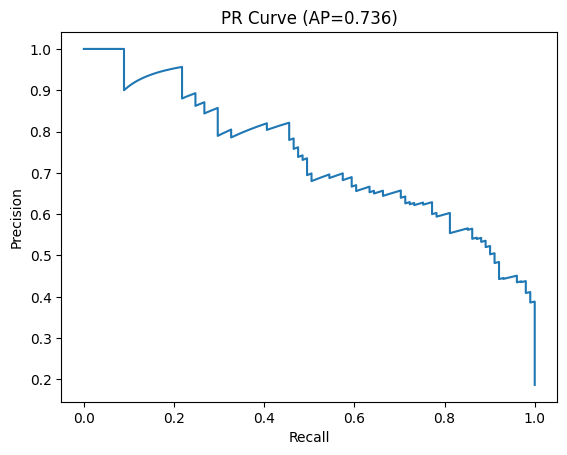

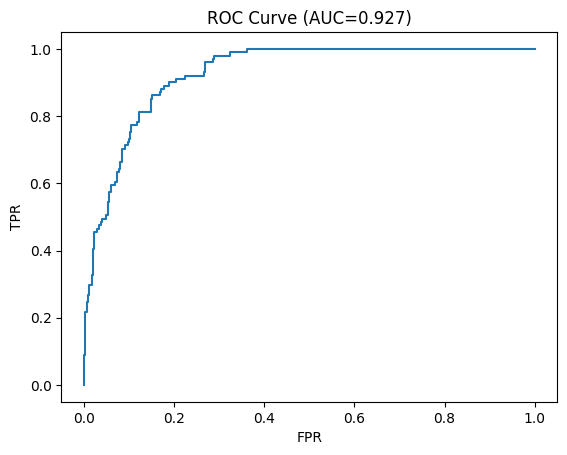

In [7]:
from src import evaluate
import sys

ckpt = str((config.RUNS_DIR / 'cnn1d_testpos_win256' / 'best.pt').as_posix())
out_dir = str((config.RUNS_DIR / 'cnn1d_testpos_win256').as_posix())
sys.argv = ['evaluate', '--ckpt', ckpt, '--out', out_dir]
evaluate.main()